# import

In [26]:
import pandas as pd
import numpy as np
import random
import os
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import torch
import torch.nn as nn
# import torch.nn.functional as F # 비선형석 첨가
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.auto import tqdm

from matplotlib import font_manager,rc
rc('font', family='AppleGothic')
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')

# Data 불러오기

In [2]:
train_df_pass = './processed_data/train_df_dl.pkl'
test_df_pass = './processed_data/test_df_dl.pkl'
# train_df_pass = './processed_data/train_df_dl_win.pkl'
# test_df_pass = './processed_data/test_df_dl_win.pkl'
train_df = pd.read_pickle(train_df_pass)
test_df = pd.read_pickle(test_df_pass)

display(train_df)
display(test_df)

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday,building_type,total_area,cooling_area,power_consumption
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,2022,6,1,0,2,152,20.584184,49.6576,1,Other_Buildings,110634.00,39570.00,1085.28
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,2022,6,1,1,2,152,19.846954,47.7625,1,Other_Buildings,110634.00,39570.00,1047.36
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,2022,6,1,2,2,152,19.317610,47.2225,1,Other_Buildings,110634.00,39570.00,974.88
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,2022,6,1,3,2,152,18.337658,44.7856,1,Other_Buildings,110634.00,39570.00,953.76
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,2022,6,1,4,2,152,19.585934,49.0061,1,Other_Buildings,110634.00,39570.00,986.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,2022,8,24,19,2,236,25.094857,63.6624,0,Hotel_and_Resort,57497.84,40035.23,881.04
203996,100_20220824 20,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,2022,8,24,20,2,236,24.244918,62.4024,0,Hotel_and_Resort,57497.84,40035.23,798.96
203997,100_20220824 21,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,2022,8,24,21,2,236,23.241700,64.1976,0,Hotel_and_Resort,57497.84,40035.23,825.12
203998,100_20220824 22,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,2022,8,24,22,2,236,23.472275,65.0744,0,Hotel_and_Resort,57497.84,40035.23,640.08


,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday,building_type,total_area,cooling_area
0,1_20220825 00,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,2022,8,25,0,3,237,25.185563,58.3456,0,Other_Buildings,110634.00,39570.00
1,1_20220825 01,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,2022,8,25,1,3,237,24.994620,57.4456,0,Other_Buildings,110634.00,39570.00
2,1_20220825 02,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,2022,8,25,2,3,237,24.495488,57.8725,0,Other_Buildings,110634.00,39570.00
3,1_20220825 03,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,2022,8,25,3,3,237,23.937118,57.9376,0,Other_Buildings,110634.00,39570.00
4,1_20220825 04,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,2022,8,25,4,3,237,23.746200,56.9961,0,Other_Buildings,110634.00,39570.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100_20220831 19,100,2022-08-31 19:00:00,22.5,0.0,0.9,84,2022,8,31,19,2,243,24.493434,61.4824,0,Hotel_and_Resort,57497.84,40035.23
16796,100_20220831 20,100,2022-08-31 20:00:00,20.7,0.0,0.4,95,2022,8,31,20,2,243,23.067551,65.2725,0,Hotel_and_Resort,57497.84,40035.23
16797,100_20220831 21,100,2022-08-31 21:00:00,20.2,0.0,0.4,98,2022,8,31,21,2,243,22.590086,66.7056,0,Hotel_and_Resort,57497.84,40035.23
16798,100_20220831 22,100,2022-08-31 22:00:00,20.1,0.0,1.1,97,2022,8,31,22,2,243,21.978649,65.7281,0,Hotel_and_Resort,57497.84,40035.23


# Fixed Random Seed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

# Hyperparameter Setting

In [4]:
# 하이퍼파라미터
param_grid = {
    input_size = 29,
    hidden_size = [32, 64, 128],
    num_layers = 2,
    output_size = 1,
    num_epochs = 5,
    window_size = 24,
    batch_size = [32, 64, 128],
    learning_rate = [0.01, 0.001, 0.001]
}

# Dataset

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df
        self.window_size = window_size

    def __len__(self): # row의 길이 반환
        return len(self.df) - self.window_size

    def __getitem__(self, idx): # dataset의 indexing
        x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
        if self.df.shape[1] > 1:
            y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)
        else:
            y = None
        return x, y

def create_data_loader(df, window_size, batch_size):
    dataset = TimeSeriesDataset(df, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader, dataset

In [6]:
# building_type 컬럼과 day_of_week 컬럼 원-핫 인코딩

# building_type용 OneHotEncoder 객체 생성
encoder = OneHotEncoder()

# building_type 컬럼을 원-핫 인코딩
encoded_data_train = encoder.fit_transform(train_df[['building_type']])
encoded_data_test = encoder.transform(test_df[['building_type']])

# 인코딩 결과를 데이터프레임으로 변환
df_encoded_train = pd.DataFrame(encoded_data_train.toarray(), columns=encoder.get_feature_names_out(['building_type']))
df_encoded_test = pd.DataFrame(encoded_data_test.toarray(), columns=encoder.get_feature_names_out(['building_type']))

train_df = pd.concat([train_df, df_encoded_train],axis=1)
test_df = pd.concat([test_df, df_encoded_test],axis=1)
# 기존 컬럼 drop
train_df = train_df.drop(columns=['building_type'])
test_df = test_df.drop(columns=['building_type'])

In [7]:
# day_of_week용 OneHotEncoder 객체 생성
encoder = OneHotEncoder()

# day_of_week 컬럼을 원-핫 인코딩
encoded_data_train = encoder.fit_transform(train_df[['day_of_week']])
encoded_data_test = encoder.transform(test_df[['day_of_week']])

# 인코딩 결과를 데이터프레임으로 변환
df_encoded_train = pd.DataFrame(encoded_data_train.toarray(), columns=encoder.get_feature_names_out(['day_of_week']))
df_encoded_test = pd.DataFrame(encoded_data_test.toarray(), columns=encoder.get_feature_names_out(['day_of_week']))

# 인코딩 결과를 데이터에 추가
train_df = pd.concat([train_df, df_encoded_train],axis=1)
test_df = pd.concat([test_df, df_encoded_test],axis=1)

# 기존 컬럼 drop
train_df = train_df.drop(columns=['day_of_week'])
test_df = test_df.drop(columns=['day_of_week'])

In [8]:
temp = train_df.pop('power_consumption')
train_df['power_consumption'] = temp

print(len(train_df.columns))
train_df.columns, test_df.columns

37


(Index(['num_date_time', 'building_number', 'date_time', 'temperature',
        'rainfall', 'windspeed', 'humidity', 'year', 'month', 'day', 'hour',
        'day_of_year', 'WCT', 'THI', 'holiday', 'total_area', 'cooling_area',
        'building_type_Apartment', 'building_type_Commercial',
        'building_type_Data_Center',
        'building_type_Department_Store_and_Outlet',
        'building_type_Discount_Mart', 'building_type_Hospital',
        'building_type_Hotel_and_Resort',
        'building_type_Knowledge_Industry_Center',
        'building_type_Other_Buildings', 'building_type_Public',
        'building_type_Research_Institute', 'building_type_University',
        'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'power_consumption'],
       dtype='object'),
 Index(['num_date_time', 'building_number', 'date_time', 'temperature',
        'rainfall', 'windspeed', 'humidity', 'year', 'month', 'day', 'ho

In [9]:
# normalization
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_df.drop(['num_date_time', 'building_number', 'date_time', 'year', 'month', 'day', 'hour', 'day_of_year'], axis=1).values)

train_loader, dataset = create_data_loader(train_data, window_size, batch_size)
x, y = dataset

# Model Define

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        return out

In [11]:
# 맥 실리콘 사용을 위한 디바이스 이동
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

current device: mps:0


# Train

In [ ]:
# 그리드 서치 객체 생성
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=3))

# 그리드 서치 실행
grid_search.fit(x, y)


# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

# 최적의 모델 가져오기
best_model = grid_search.best_estimator_

# 모델을 사용하여 예측 수행
predictions = []
for inputs, _ in dataloader:
    with torch.no_grad():
        outputs = best_model(inputs)
        predictions.append(outputs.numpy())
        
predictions = np.vstack(predictions)

In [12]:
# Train
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 1000 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
            
print('==================== 학습 완료 ====================')

Epoch [1/5], Step [1000/3188], Loss: 0.0137
Epoch [1/5], Step [2000/3188], Loss: 0.0001
Epoch [1/5], Step [3000/3188], Loss: 0.0033
Epoch [2/5], Step [1000/3188], Loss: 0.0389
Epoch [2/5], Step [2000/3188], Loss: 0.0001
Epoch [2/5], Step [3000/3188], Loss: 0.0039
Epoch [3/5], Step [1000/3188], Loss: 0.0097
Epoch [3/5], Step [2000/3188], Loss: 0.0001
Epoch [3/5], Step [3000/3188], Loss: 0.0024
Epoch [4/5], Step [1000/3188], Loss: 0.0037
Epoch [4/5], Step [2000/3188], Loss: 0.0001
Epoch [4/5], Step [3000/3188], Loss: 0.0014
Epoch [5/5], Step [1000/3188], Loss: 0.0024
Epoch [5/5], Step [2000/3188], Loss: 0.0001
Epoch [5/5], Step [3000/3188], Loss: 0.0011
==================== 학습 완료 ====================


# Test Data Pre-processing

In [13]:
# 학습 데이터에서 마지막 행 가져오기
last_train_data = train_df.drop(['num_date_time', 'building_number', 'date_time', 'year', 'month', 'day', 'hour', 'day_of_year'], axis=1).loc[204000-24:,:]

# 전력소비량 열 생성
final_df = pd.concat((test_df.drop(['num_date_time', 'building_number', 'date_time', 'year', 'month', 'day', 'hour', 'day_of_year'], axis=1), pd.DataFrame(np.zeros(test_df.shape[0]))),axis=1)
final_df = final_df.rename({0:'power_consumption'},axis=1)

# Test Dataset

In [14]:
test_df = pd.concat((last_train_data, final_df)).reset_index(drop=True)
test_data = scaler.transform(test_df.values) # train과 동일하게 scaling
test_data.shape

(16824, 29)

In [15]:
# Dataset & DataLoader
test_dataset = TimeSeriesDataset(test_data, window_size)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Inference

In [16]:
model.eval()

test_predictions = []

with torch.no_grad():
    for i in tqdm(range(test_data.shape[0] - window_size)):
        x = torch.Tensor(test_data[i:i+window_size,:]).to(device)
        new_x = model(x.view(1,window_size,-1))
        
        test_data[i+window_size,-1] = new_x # 입력 업데이트
        test_predictions.append(new_x.detach().cpu().numpy().item()) # 예측 결과 저장

100%|██████████████████████████████████████████████████████████████████| 16800/16800 [00:37<00:00, 444.68it/s]


# Submit

In [17]:
predictions = scaler.inverse_transform(test_data)[24:,-1] # 원래 scale로 복구

In [18]:
sample_submission = pd.read_csv('./input/sample_submission.csv')

In [19]:
sample_submission['answer'] = predictions
sample_submission

,num_date_time,answer
0,1_20220825 00,522.555038
1,1_20220825 01,1607.745740
2,1_20220825 02,1916.028618
3,1_20220825 03,2068.721759
4,1_20220825 04,2207.978856
...,...,...
16795,100_20220831 19,794.161686
16796,100_20220831 20,720.048190
16797,100_20220831 21,637.303205
16798,100_20220831 22,597.653278


In [20]:
current_time = datetime.now()
formatted_time = current_time.strftime("%Y%m%d_%H%M%S")
sample_submission.to_csv(f'./result/{formatted_time}_lstm_baseline_submission.csv', index=False)

# 결과 시각화

In [21]:
train_df = pd.read_pickle(train_df_pass)
test_df = pd.read_pickle(test_df_pass)

In [22]:
test_df['power_consumption'] = sample_submission['answer']
final_df = pd.concat([train_df, test_df])
final_df

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,year,month,day,hour,day_of_week,day_of_year,WCT,THI,holiday,building_type,total_area,cooling_area,power_consumption
0,1_20220601 00,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,2022,6,1,0,2,152,20.584184,49.6576,1,Other_Buildings,110634.00,39570.00,1085.280000
1,1_20220601 01,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,2022,6,1,1,2,152,19.846954,47.7625,1,Other_Buildings,110634.00,39570.00,1047.360000
2,1_20220601 02,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,2022,6,1,2,2,152,19.317610,47.2225,1,Other_Buildings,110634.00,39570.00,974.880000
3,1_20220601 03,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,2022,6,1,3,2,152,18.337658,44.7856,1,Other_Buildings,110634.00,39570.00,953.760000
4,1_20220601 04,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,2022,6,1,4,2,152,19.585934,49.0061,1,Other_Buildings,110634.00,39570.00,986.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100_20220831 19,100,2022-08-31 19:00:00,22.5,0.0,0.9,84.0,2022,8,31,19,2,243,24.493434,61.4824,0,Hotel_and_Resort,57497.84,40035.23,794.161686
16796,100_20220831 20,100,2022-08-31 20:00:00,20.7,0.0,0.4,95.0,2022,8,31,20,2,243,23.067551,65.2725,0,Hotel_and_Resort,57497.84,40035.23,720.048190
16797,100_20220831 21,100,2022-08-31 21:00:00,20.2,0.0,0.4,98.0,2022,8,31,21,2,243,22.590086,66.7056,0,Hotel_and_Resort,57497.84,40035.23,637.303205
16798,100_20220831 22,100,2022-08-31 22:00:00,20.1,0.0,1.1,97.0,2022,8,31,22,2,243,21.978649,65.7281,0,Hotel_and_Resort,57497.84,40035.23,597.653278


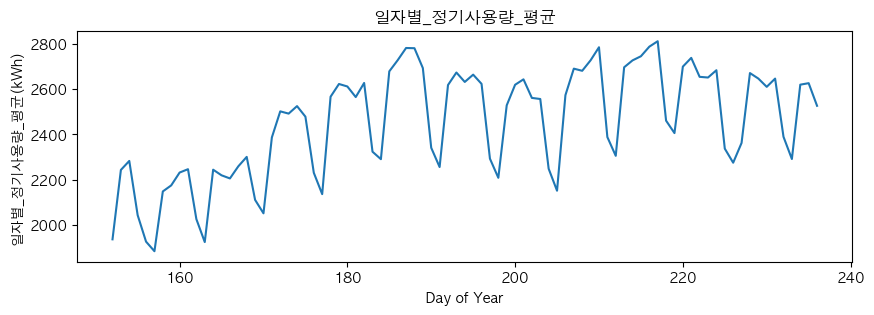

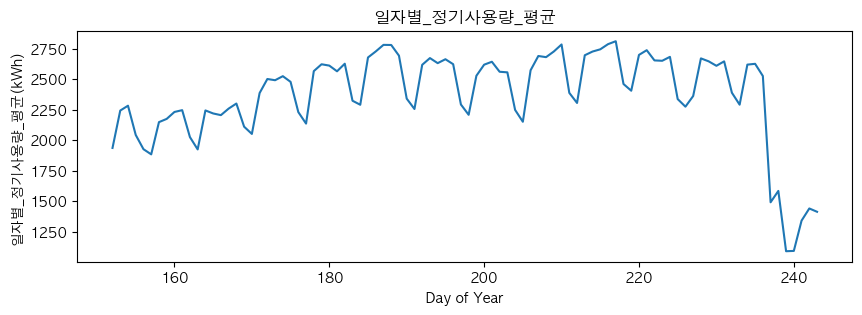

In [23]:
일자별_정기사용량_평균 = train_df.groupby('day_of_year').power_consumption.mean()
plt.figure(figsize=(10, 3))
plt.plot(일자별_정기사용량_평균.index,일자별_정기사용량_평균.values)
plt.title('일자별_정기사용량_평균')
plt.xlabel('Day of Year')
plt.ylabel('일자별_정기사용량_평균(kWh)')
plt.show()

일자별_정기사용량_평균 = final_df.groupby('day_of_year').power_consumption.mean()
plt.figure(figsize=(10, 3))
plt.plot(일자별_정기사용량_평균.index,일자별_정기사용량_평균.values)
plt.title('일자별_정기사용량_평균')
plt.xlabel('Day of Year')
plt.ylabel('일자별_정기사용량_평균(kWh)')
plt.show()

In [24]:
# 20번 건물의 연면적, 냉방면적 보정
# 요일 정보 One-Hot인코딩
# 냉방면적 보정: 아파트, 지식산업센터

In [25]:
# ![Unknown.jpg](attachment:Unknown.jpg)